In [1]:
!python -V

Python 3.9.7


In [1]:
import pandas as pd

In [2]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [19]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("green-nyc-taxi-experiment")

2024/05/25 16:02:21 INFO mlflow.tracking.fluent: Experiment with name 'green-nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/mlops/02-experiment-tracking/mlruns/1', creation_time=1716667341989, experiment_id='1', last_update_time=1716667341989, lifecycle_stage='active', name='green-nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.060351532943308

C:\Users\abhis\AppData\Local\Temp\ipykernel_21804\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
e:\Anaconda3\envs\mlops\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\abhis\AppData\Local\Temp\ipykernel_21804\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simila

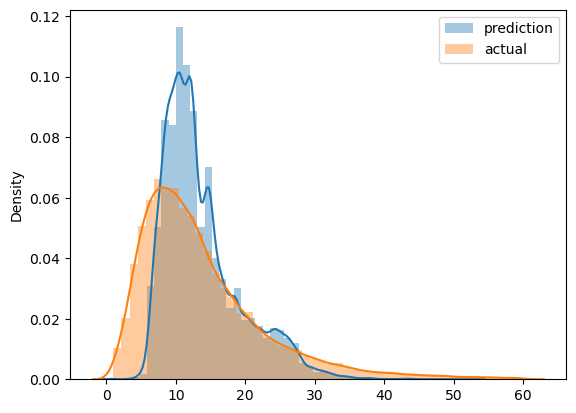

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [11]:
len(df_train), len(df_val)

(65946, 62574)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.037299860390432

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
with mlflow.start_run():
    mlflow.set_tag("developer","abhishek")
    mlflow.log_param("train-data-path","./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","./data/green_tripdata_2023-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.30685                           
[1]	validation-rmse:7.52947                           
[2]	validation-rmse:6.94524                           
[3]	validation-rmse:6.51127                           
[4]	validation-rmse:6.19202                           
[5]	validation-rmse:5.96045                           
[6]	validation-rmse:5.79256                           
[7]	validation-rmse:5.66864                           
[8]	validation-rmse:5.58028                           
[9]	validation-rmse:5.51497                           
[10]	validation-rmse:5.46776                          
[11]	validation-rmse:5.43320                          
[12]	validation-rmse:5.40758                          
[13]	validation-rmse:5.38868                          
[14]	validation-rmse:5.37428                          
[15]	validation-rmse:5.36273                          
[16]	validation-rmse:5.35393                          
[17]	validation-rmse:5.34639                          
[18]	valid

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:15:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92683                                                    
[1]	validation-rmse:8.56658                                                    
[2]	validation-rmse:8.23896                                                    
[3]	validation-rmse:7.94168                                                    
[4]	validation-rmse:7.67226                                                    
[5]	validation-rmse:7.42868                                                    
[6]	validation-rmse:7.20906                                                    
[7]	validation-rmse:7.01121                                                    
[8]	validation-rmse:6.83303                                                    
[9]	validation-rmse:6.67324                                                    
[10]	validation-rmse:6.53009                                                   
[11]	validation-rmse:6.40236                                                   
[12]	validation-rmse:6.28816            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.35212                                                    
[1]	validation-rmse:7.58929                                                    
[2]	validation-rmse:7.00085                                                    
[3]	validation-rmse:6.54859                                                    
[4]	validation-rmse:6.20651                                                    
[5]	validation-rmse:5.95279                                                    
[6]	validation-rmse:5.75533                                                    
[7]	validation-rmse:5.62083                                                    
[8]	validation-rmse:5.51230                                                    
[9]	validation-rmse:5.43317                                                    
[10]	validation-rmse:5.37691                                                   
[11]	validation-rmse:5.33583                                                   
[12]	validation-rmse:5.30159            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99794                                                    
[1]	validation-rmse:8.69593                                                    
[2]	validation-rmse:8.41493                                                    
[3]	validation-rmse:8.15389                                                    
[4]	validation-rmse:7.91127                                                    
[5]	validation-rmse:7.68672                                                    
[6]	validation-rmse:7.47810                                                    
[7]	validation-rmse:7.28555                                                    
[8]	validation-rmse:7.10731                                                    
[9]	validation-rmse:6.94386                                                    
[10]	validation-rmse:6.79170                                                   
[11]	validation-rmse:6.65311                                                   
[12]	validation-rmse:6.52483            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.37572                                                    
[1]	validation-rmse:5.22300                                                    
[2]	validation-rmse:5.21585                                                    
[3]	validation-rmse:5.21553                                                    
[4]	validation-rmse:5.20985                                                    
[5]	validation-rmse:5.20348                                                    
[6]	validation-rmse:5.20553                                                    
[7]	validation-rmse:5.19460                                                    
[8]	validation-rmse:5.19128                                                    
[9]	validation-rmse:5.18923                                                    
[10]	validation-rmse:5.18725                                                   
[11]	validation-rmse:5.18904                                                   
[12]	validation-rmse:5.18281            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.12137                                                    
[1]	validation-rmse:5.39843                                                    
[2]	validation-rmse:5.24940                                                    
[3]	validation-rmse:5.20837                                                    
[4]	validation-rmse:5.18682                                                    
[5]	validation-rmse:5.18256                                                    
[6]	validation-rmse:5.18172                                                    
[7]	validation-rmse:5.17781                                                    
[8]	validation-rmse:5.17376                                                    
[9]	validation-rmse:5.17234                                                    
[10]	validation-rmse:5.17051                                                   
[11]	validation-rmse:5.16843                                                   
[12]	validation-rmse:5.16468            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.44485                                                    
[1]	validation-rmse:5.68040                                                    
[2]	validation-rmse:5.48497                                                    
[3]	validation-rmse:5.41793                                                    
[4]	validation-rmse:5.38644                                                    
[5]	validation-rmse:5.36490                                                    
[6]	validation-rmse:5.34721                                                    
[7]	validation-rmse:5.34234                                                    
[8]	validation-rmse:5.33686                                                    
[9]	validation-rmse:5.33308                                                    
[10]	validation-rmse:5.32924                                                   
[11]	validation-rmse:5.32858                                                   
[12]	validation-rmse:5.31641            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93588                                                    
[1]	validation-rmse:8.58312                                                    
[2]	validation-rmse:8.26230                                                    
[3]	validation-rmse:7.96876                                                    
[4]	validation-rmse:7.69960                                                    
[5]	validation-rmse:7.45614                                                    
[6]	validation-rmse:7.23412                                                    
[7]	validation-rmse:7.03163                                                    
[8]	validation-rmse:6.84981                                                    
[9]	validation-rmse:6.68565                                                    
[10]	validation-rmse:6.54471                                                   
[11]	validation-rmse:6.41011                                                   
[12]	validation-rmse:6.28905            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.87698                                                    
[1]	validation-rmse:5.89255                                                    
[2]	validation-rmse:5.53701                                                    
[3]	validation-rmse:5.38331                                                    
[4]	validation-rmse:5.34481                                                    
[5]	validation-rmse:5.32385                                                    
[6]	validation-rmse:5.31527                                                    
[7]	validation-rmse:5.31196                                                    
[8]	validation-rmse:5.30569                                                    
[9]	validation-rmse:5.30469                                                    
[10]	validation-rmse:5.29886                                                   
[11]	validation-rmse:5.29437                                                   
[12]	validation-rmse:5.29500            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60532                                                    
[1]	validation-rmse:8.00729                                                    
[2]	validation-rmse:7.51246                                                    
[3]	validation-rmse:7.10557                                                    
[4]	validation-rmse:6.77376                                                    
[5]	validation-rmse:6.50428                                                    
[6]	validation-rmse:6.28787                                                    
[7]	validation-rmse:6.11443                                                    
[8]	validation-rmse:5.97527                                                    
[9]	validation-rmse:5.86524                                                    
[10]	validation-rmse:5.77634                                                   
[11]	validation-rmse:5.70604                                                   
[12]	validation-rmse:5.64923            

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72303                                                     
[1]	validation-rmse:8.20420                                                     
[2]	validation-rmse:7.75728                                                     
[3]	validation-rmse:7.37449                                                     
[4]	validation-rmse:7.04727                                                     
[5]	validation-rmse:6.76783                                                     
[6]	validation-rmse:6.53253                                                     
[7]	validation-rmse:6.33351                                                     
[8]	validation-rmse:6.16623                                                     
[9]	validation-rmse:6.02585                                                     
[10]	validation-rmse:5.90674                                                    
[11]	validation-rmse:5.80705                                                    
[12]	validation-rmse:5.72406

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.05222                                                     
[1]	validation-rmse:6.05770                                                     
[2]	validation-rmse:5.65722                                                     
[3]	validation-rmse:5.49581                                                     
[4]	validation-rmse:5.42189                                                     
[5]	validation-rmse:5.38154                                                     
[6]	validation-rmse:5.35569                                                     
[7]	validation-rmse:5.34135                                                     
[8]	validation-rmse:5.33083                                                     
[9]	validation-rmse:5.32443                                                     
[10]	validation-rmse:5.31428                                                    
[11]	validation-rmse:5.30644                                                    
[12]	validation-rmse:5.30389

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32343                                                     
[1]	validation-rmse:7.54713                                                     
[2]	validation-rmse:6.95054                                                     
[3]	validation-rmse:6.50077                                                     
[4]	validation-rmse:6.16521                                                     
[5]	validation-rmse:5.91676                                                     
[6]	validation-rmse:5.73378                                                     
[7]	validation-rmse:5.60115                                                     
[8]	validation-rmse:5.50389                                                     
[9]	validation-rmse:5.42872                                                     
[10]	validation-rmse:5.37557                                                    
[11]	validation-rmse:5.33522                                                    
[12]	validation-rmse:5.30605

e:\Anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

e:\Anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.71349                                                     
[1]	validation-rmse:6.71555                                                     
[2]	validation-rmse:6.11681                                                     
[3]	validation-rmse:5.76798                                                     
[4]	validation-rmse:5.56467                                                     
[5]	validation-rmse:5.44729                                                     
[6]	validation-rmse:5.37397                                                     
[7]	validation-rmse:5.33179                                                     
[8]	validation-rmse:5.30420                                                     
[9]	validation-rmse:5.28533                                                     
[10]	validation-rmse:5.27109                                                    
[11]	validation-rmse:5.26105                                                    
[12]	validation-rmse:5.25630

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)